In [1]:
import pandas as pd
pd.set_option('display.max_columns', 101)
pd.set_option('display.max_rows', 101)
pd.options.mode.chained_assignment = None
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [176]:
def set_labels(ax, total, title, x_label, y_label):
    '''this function set plot title and labels'''
    ax.set_title(title, fontsize=22)
    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=15) 

def plot_dist_and_fraud_pct(df, col):
    '''this function draws the distribution of categorical values and percentage of transaction frauds per value'''
    df_bar = (df.groupby([col])['isFraud'].mean()*100).reset_index() 
    plt.figure(figsize=(16,6))
    g = sns.countplot(x=col, data=df, order=list(df_bar[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='isFraud', data=df_bar, 
                        color='black', order=list(df_bar[col].values))
    gt.set_ylabel("% of Transaction Frauds", fontsize=10)
    g.set_title("{} Values Distribution and % of Transaction Frauds".format(col_alias[col]), fontsize=12)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_xlabel("{} Values".format(col_alias[col]), fontsize=10)
    g.set_ylabel("# Transaction Records", fontsize=10)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/len(df)*100),
                ha="center",fontsize=11) 
    plt.show()
    
def keep_top_levels(df, col, explained_ratio = 0.95):
    '''this function describe top levels with most reocrds of selected feature'''
    df_sum = df[col].value_counts().sort_values(ascending = False).reset_index()
    df_sum.columns = ['feature','count']
    df_sum['cumsum_pct'] = np.round(100*(df_sum['count'].cumsum()/df_sum['count'].sum()),1)

    top_levels = df_sum.loc[df_sum['cumsum_pct'] <= explained_ratio*100, 'feature'].values.tolist()
    
    if len(top_levels) < 2:
        top_levels = df_sum.loc[:1, 'feature'].values.tolist()
    print('------------------------------------------------------------------------------------------------------------')
    print('{} has {} unique levels.'.format(col, len(df_sum)))
    print('top {} levels account for {}% of the total population.'.format(len(top_levels),
                                                                round(df_sum[df_sum['feature'].isin(top_levels)]['cumsum_pct'].max(),2)))
    
    if df[col].nunique() > len(top_levels) + 1:
        df.loc[:, col] = np.where(df[col].isin(top_levels), df[col], 'Others')
    
    return df, top_levels

def plot_missing_pct(df, features, feature_name):
    '''this function draw bar plot of missing value percentage '''
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    
    ax.bar(features, df[features].isnull().mean())
    ax.set_ylim(0,1)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('% missing data')
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    plt.title('Percentage of missing values of {}'.format(feature_name))
    plt.show()
    
def plot_dist_and_fraud_pct_plotly(df, col, top_n = 5):
    df_plot = df.groupby(col).agg(records_num = ('isFraud', 'size'),
                                     records_ratio = ('isFraud',lambda x: np.round(len(x)/len(df)*100, 2)), 
                                     fraud_ratio = ('isFraud', lambda x: np.round(x.mean()*100, 2))).reset_index()
    df_plot = df_plot.sort_values('records_num', ascending=False).head(top_n)
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Bar(
            x=df_plot[col],
            y=df_plot.records_num,
            text=[str(x)+'%' for x in df_plot.records_ratio],
            textposition='auto',
            name='Count'
        ),secondary_y=False)

    fig.add_trace(
        go.Scatter(
            x=df_plot[col],
            y=df_plot.fraud_ratio,
            name='Fraud Ratio'
        ),secondary_y=True)

    fig.update_layout(
        title_text="{} Values Distribution and % of Transaction Frauds".format(col_alias[col])
    )

    fig.update_xaxes(title_text=col_alias[col])
    fig.update_yaxes(title_text="# transaction records", secondary_y=False)
    fig.update_yaxes(title_text="% fraud records", secondary_y=True)

    fig.show()
    
def plot_time_dist_and_fraud_pct_plotly(df, col):
    df_plot = df.groupby(col).agg(records_num = ('isFraud', 'size'),
                                     records_ratio = ('isFraud',lambda x: np.round(len(x)/len(df)*100, 2)), 
                                     fraud_ratio = ('isFraud', lambda x: np.round(x.mean()*100, 2))).reset_index()
    df_plot = df_plot.sort_values(col)
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Bar(
            x=df_plot[col],
            y=df_plot.records_num,
            marker={'color': df_plot[col],
                    'colorscale': 'Spectral'},
            text=[str(x)+'%' for x in df_plot.records_ratio],
            textposition='auto',
            name='Count'
        ),secondary_y=False)

    fig.add_trace(
        go.Scatter(
            x=df_plot[col],
            y=df_plot.fraud_ratio,
            name='Fraud Ratio'
        ),secondary_y=True)

    fig.update_layout(
        title_text="{} Values Distribution and % of Transaction Frauds".format(col_alias[col])
    )

    fig.update_xaxes(title_text=col_alias[col])
    fig.update_yaxes(title_text="# transaction records", secondary_y=False)
    fig.update_yaxes(title_text="% fraud records", secondary_y=True)

    fig.show()

In [2]:
# data folder path
data_path = '../data'

# data file name
train_id_file = 'train_identity.csv'
train_trans_file = 'train_transaction.csv'
# test_id_file = 'test_identity.csv'
# test_trans_file = 'test_transaction.csv'

# read data file as pd dataframe
train_id = pd.read_csv(os.path.join(data_path, train_id_file))
train_trans = pd.read_csv(os.path.join(data_path, train_trans_file))
# test_id = pd.read_csv(os.path.join(data_path, test_id_file))
# test_trans = pd.read_csv(os.path.join(data_path, test_trans_file))

# merge id and transcation dfs
train = pd.merge(train_trans, train_id, on='TransactionID', how='left')
# test = pd.merge(test_trans, test_id, on='TransactionID', how='left')

In [3]:
# delete initial dfs
del train_id, train_trans
# del train_id, train_trans, test_id, test_trans

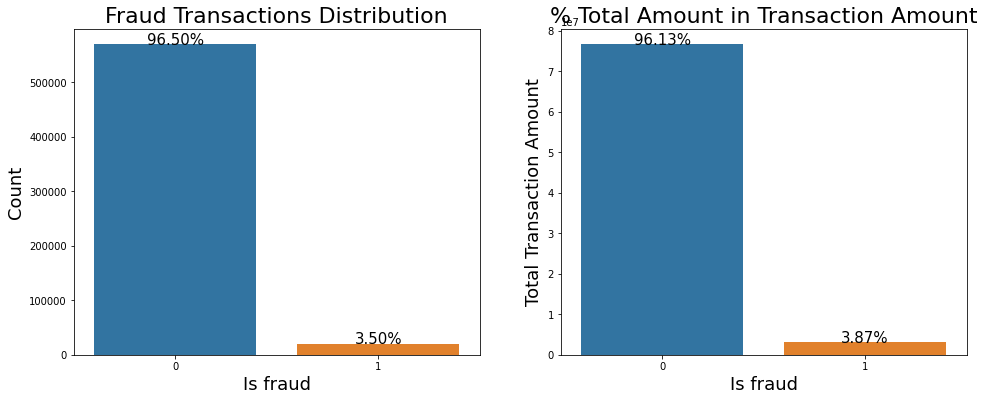

In [5]:
# plot fraud distribution by count and total amount
plt.figure(figsize=(16,6))
plt.subplot(121)
ax = sns.countplot(x='isFraud', data=train)
set_labels(ax, len(train), 'Fraud Transactions Distribution', 'Is fraud', 'Count')
plt.subplot(122)
df_bar = train.groupby(['isFraud'])['TransactionAmt'].sum().reset_index()
ax = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=df_bar)
set_labels(ax, df_bar['TransactionAmt'].sum(), '% Total Amount in Transaction Amount', 'Is fraud', 'Total Transaction Amount')

In [37]:
# make a copy of train df
df = train.copy()

In [38]:
# email features: P_emaildomain, R_emaildomain
# email map
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# fill na
df.loc[:, ['P_emaildomain', 'R_emaildomain']] = df[['P_emaildomain', 'R_emaildomain']].fillna('None')

# clean email domains
df = df.assign(P_emaildomain_bin = df['P_emaildomain'].map(emails),
          P_emaildomain_suffix = df['P_emaildomain'].map(lambda x: str(x).split('.')[-1]).map(lambda x: 'us' if str(x) in us_emails else x),
          R_emaildomain_bin = df['R_emaildomain'].map(emails),
          R_emaildomain_suffix = df['R_emaildomain'].map(lambda x: str(x).split('.')[-1]).map(lambda x: 'us' if str(x) in us_emails else x),
        )
# fill na
df.loc[:, ['P_emaildomain_bin', 'R_emaildomain_bin']] = df[['P_emaildomain_bin', 'R_emaildomain_bin']].fillna('None')

df.drop(['P_emaildomain', 'R_emaildomain'], axis=1, inplace=True)

In [39]:
# deveice features: DeviceInfo, DeviceType
# device map
devices = {'SM': 'Samsung', 'SAMSUNG': 'Samsung', 'GT-': 'Samsung', 'Moto G': 'Motorola',
           'Moto': 'Motorola', 'moto': 'Motorola', 'LG-': 'LG', 'VS\d{3}': 'LG', 'LG\w{2}\d{3}': 'LG', 'rv': 'RV', 'HUAWEI': 'Huawei',
           'ALE-':'Huawei', '-L':'Huawei', 'hi6210sft': 'Huawei', 'CHC-U03': 'Huawei', 'Blade': 'ZTE', 'Z\d{3}': 'ZTE', 'BLADE': 'ZTE', 'ZTE':'ZTE', 
           'Linux': 'Linux', 'XT': 'Sony', 'F\d{4}': 'Sony', 'E\d{4}': 'Sony', 'G\d{4}': 'Sony', 'HTC': 'HTC', 'ASUS': 'Asus',
           'Pixel': 'Pixel', 'Lenovo': 'Lenovo', 'Windows': 'Windows', 'Redmi': 'Redmi', 'Ilium': 'Ilium', 'ILIUM': 'Ilium',
           'Hisense': 'Hisense', 'KF': 'Amazon', 'Android': 'Android', '\d{4}A': 'Alcatel', '\d{4}W': 'Alcatel', '\d{4}M': 'Alcatel', 
           'Alcatel': 'Alcatel', 'ALCATEL':'Alcatel', '\d{4}G': 'Mozilla', 'M4': 'M4', 'TA-': 'Nokia', 'NOKIA': 'Nokia', 'Nexus':'Nexus', 'BLU':'BLU'}

# devices_list = df.loc[:,'device_name'].value_counts().where(lambda x : x>80).dropna().index.values

devices_list = ['None', 'Windows', 'iOS Device', 'MacOS', 'Samsung', 'Trident', 'RV',
               'Motorola', 'LG', 'Huawei', 'Sony', 'ZTE', 'HTC', 'Alcatel', 'Lenovo',
               'Ilium', 'Pixel', 'Hisense', 'Amazon', 'Mozilla', 'M4', 'Redmi',
               'Nokia', 'Linux', 'Nexus', 'Android']

# clean device name
df.loc[:,'DeviceName'] = df['DeviceInfo'].str.split('/').str[0].fillna('None')
for k,v in devices.items():
    df.loc[df['DeviceName'].str.contains(k, na=False), 'DeviceName'] = v
df.loc[~df['DeviceName'].isin(devices_list), 'DeviceName'] = 'Others'

# remove DeviceInfo
df.drop(['DeviceInfo'], axis=1, inplace=True)

# DeviceType - fillna
df.loc[:,'DeviceType'] = df['DeviceType'].fillna('None')

In [40]:
# transaction dt
START_DATE = '2017-12-01'
startdate = dt.datetime.strptime(START_DATE, "%Y-%m-%d")
df["Transaction_Date"] = df['TransactionDT'].apply(lambda x: (startdate + dt.timedelta(seconds=x)))
df['Transaction_Weekdays'] = df['Transaction_Date'].dt.dayofweek
df['Transaction_Hours'] = df['Transaction_Date'].dt.hour
df['Transaction_Days'] = df['Transaction_Date'].dt.day
df['Transaction_Months'] = df['Transaction_Date'].dt.month

In [41]:
id_features = df.columns[df.columns.str.contains('id_\d+')]
cate_id_features = ['id_'+str(x).zfill(2) for x in range(12, 38+1)]
num_id_features = ['id_'+str(x).zfill(2) for x in range(1, 12)]

# int to float
cate_id_features_to_int = df[cate_id_features].dtypes.where(lambda x: x == 'float64').dropna().index
df.loc[:, cate_id_features_to_int] = df.loc[:, cate_id_features_to_int].astype('Int64')

# int to str
df.loc[:, cate_id_features_to_int] = df.loc[:, cate_id_features_to_int].astype(str)

# fill na with None
df[cate_id_features] = df[cate_id_features].fillna('None')

# id - system
df['sys_id_30'] = df['id_30'].str.split(' ').str[0]
sys_list = ['Windows', 'iOS', 'Mac', 'Android', 'Linux', 'None']
df['sys_id_30'] = np.where(df['sys_id_30'].isin(sys_list), df['sys_id_30'], 'None')

# id - browser
browsers = {'safari': 'safari', 'chrome': 'chrome', 'samsung': 'samsung', 'Samsung': 'samsung', 'edge': 'edge', 
 'firefox': 'firefox', 'ie':'ie', 'google':'google', 'other':'others', 'None':'None'}
browsers_list = ['chrome','safari','ie','firefox','edge','samsung','None']
for k,v in browsers.items():
    df.loc[df['id_31'].str.contains(k, na=False), 'browser_id_31'] = v
df.loc[~df['browser_id_31'].isin(browsers_list), 'browser_id_31'] = 'others'

# id - screen
df.loc[df['id_33']=='0x0', 'id_33'] = 'None'
screen_height = df.loc[df['id_33']!='None', 'id_33'].str.split('x').str[1].astype(int)
bins = [0, 900, 1500, np.inf]
screen_height_cate = pd.cut(screen_height, bins, labels=['s', 'm', 'l'])
screen_width = df.loc[df['id_33']!='None', 'id_33'].str.split('x').str[0].astype(int)
bins = [0, 1200, 2000, np.inf]
screen_width_cate = pd.cut(screen_width, bins, labels=['s', 'm', 'l'])

screen = screen_width_cate.astype(str) + 'x' + screen_height_cate.astype(str)
df.loc[df['id_33']!='None', 'screen_id_33'] = screen
df.loc[df['id_33']=='None', 'screen_id_33'] = 'None'

# drop id 30, 31, 33
df.drop(['id_30','id_31','id_33'], axis=1, inplace=True)

In [42]:
# other categorical features (address, card, M features)
addr_features = df.columns[df.columns.str.contains('addr')].values.tolist()
card_features = df.columns[df.columns.str.contains('card')].values.tolist()
m_features = df.columns[df.columns.str.contains('M\d+')].values.tolist()

# int to float
features_to_int = df[addr_features+card_features].dtypes.where(lambda x: x == 'float64').dropna().index
df.loc[:, features_to_int] = df.loc[:, features_to_int].astype('Int64')

# int to str
df.loc[:, addr_features+card_features] = df.loc[:, addr_features+card_features].astype(str)

# fill na
df.loc[:, addr_features+card_features+m_features] = df[addr_features+card_features+m_features].fillna('None')

In [66]:
# clean card type
df['card6'] = df['card6'].map(lambda x: 'None' if x not in ['debit', 'credit', 'None'] else x)

In [45]:
# check missing value
all_cate_featues = df.dtypes.where(df.dtypes == 'object').dropna().index.values.tolist()
pd.DataFrame(df[all_cate_featues].isnull().mean().sort_values(ascending=False), columns = ['Missing Percentage']).head()

,Missing Percentage
screen_id_33,0.0
M4,0.0
id_16,0.0
id_15,0.0
id_14,0.0


In [148]:
# save to pickle
df.to_pickle('../output/cleaned_train.pkl', protocol=3)

In [157]:
col_alias = {'ProductCD':'Product CD',
             'card4':'Card Network Processor',
             'card6':'Card Type',
             'DeviceType':'Device Type',
             'DeviceName':'Device Name',
             'sys_id_30':'System',
             'browser_id_31':'Browser',
             'screen_id-33':'Screen Size',
             'P_emaildomain_bin':'Primary Email Domain BIN',
             'P_emaildomain_suffix':'Primary Email Domain Suffix',
             'R_emaildomain_bin':'Alternative Email Domain BIN',
             'R_emaildomain_suffix':'Alternative Email Domain Suffix',
             'Transaction_Weekdays':'Transaction Weekday',
             'Transaction_Hours':'Transaction Hour of Day',
             'Transaction_Days':'Transaction Day of Month',
             'Transaction_Months':'Transaction Month'
}

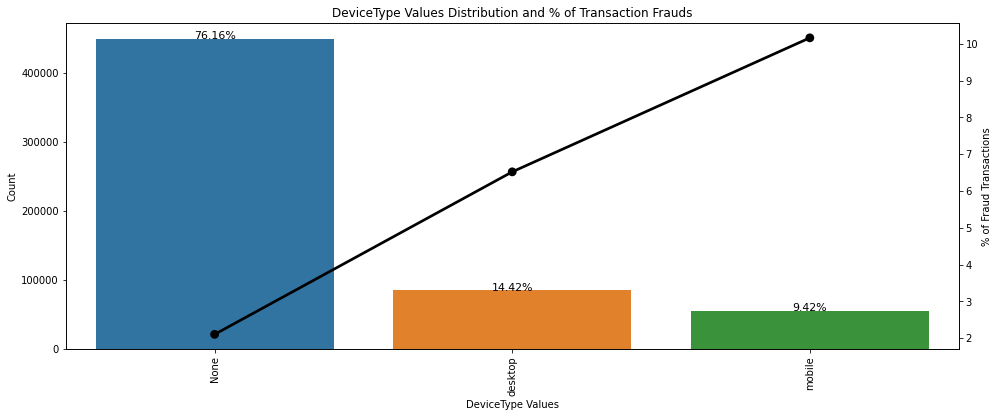

In [151]:
# plot distribution and fraud ratio
plot_dist_and_fraud_pct_plotly(df, 'DeviceType', top_n = 5)
plot_dist_and_fraud_pct(df, 'DeviceType')

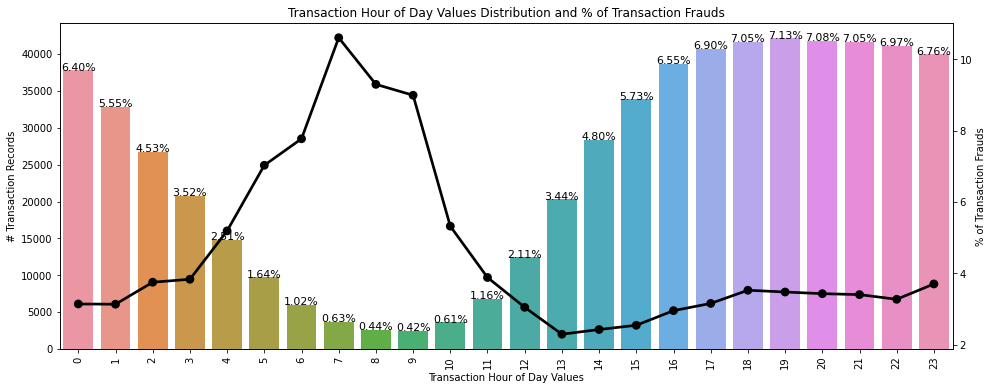

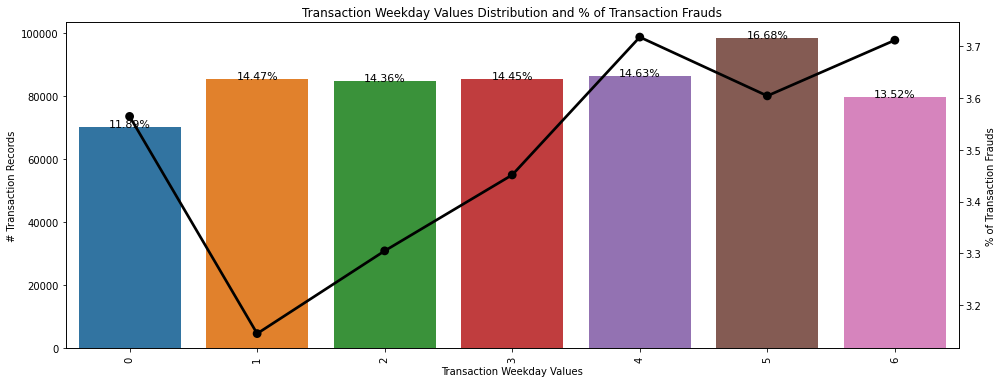

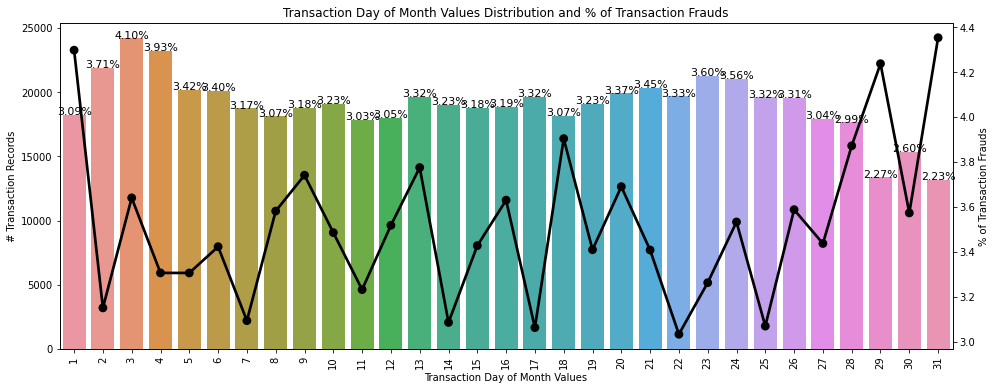

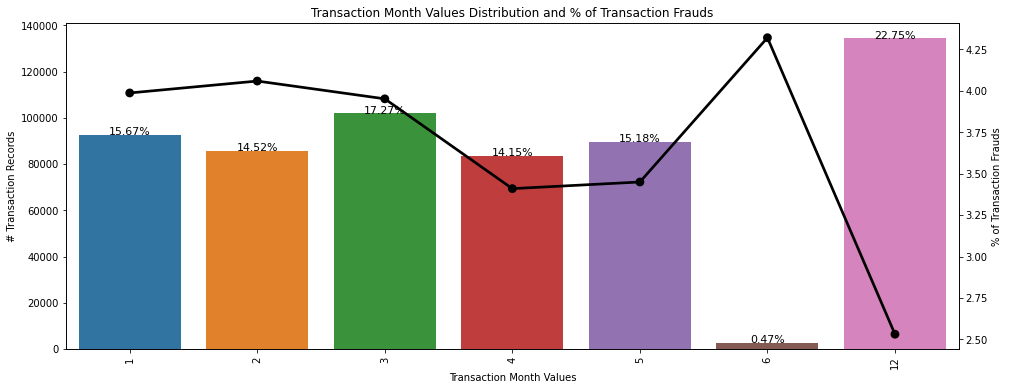

In [177]:
# plot fraud distribution by transaction dt
for col in ['Transaction_Hours', 'Transaction_Weekdays', 'Transaction_Days', 'Transaction_Months']:
    plot_dist_and_fraud_pct(df, col)
    plot_time_dist_and_fraud_pct_plotly(df, col)